# Read Packages

In [1]:
#Python Packages
import os
import math
import copy
from glob import glob
import shutil
import xml.dom.minidom
from xml.dom.minidom import parseString
import xml.etree.ElementTree as et
from xml.dom import minidom

#standard install
import cv2
import tqdm
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.metrics import structural_similarity as compare_ssim
#Parsing/Modifying XML
from lxml.etree import Element,SubElement,tostring

import data_eng.az_proc as ap
import data_eng.form_calcs as fc
import data_eng.compare as compare

In [11]:
def compare_images_test(t_2_chip, labeled_img, scores):
    gray_t_2_chip = cv2.cvtColor(t_2_chip.astype(np.uint8), cv2.COLOR_BGR2GRAY) # make gray
    gray_labeled_image = cv2.cvtColor(labeled_img.astype(np.uint8), cv2.COLOR_BGR2GRAY) #image that has been chipped from tile

    score = compare_ssim(gray_t_2_chip, gray_labeled_image, win_size = 3) #set window size so that is works on the edge peices
    scores.append(score)
    return(scores)

def copy_and_replace_images_xml(img_name, img_path, xml_path, copy_dir):
    ####
    new_img_path = os.path.join(copy_dir, "chips_positive", img_name + ".jpg")
    shutil.copy(img_path, new_img_path)

    new_xml_path = os.path.join(copy_dir, "chips_positive_xml", img_name + ".xml")
    shutil.copy(xml_path, new_xml_path) #destination

def compare_imgs_wo_blk_pxls_state_yr_std_from_6_digit_xy_idxs_test(correct_img_wo_black_sq, correct_img_wo_black_sq_path,
                                                                            compile_dir, state_year_six_digit_idx_list,
                                                                            state_year_img_paths, state_year_xml_paths,
                                                                            yx_list, standard_img_paths, standard_xml_paths):
    #process correct img (wo black sq) info
    correct_img_name = os.path.splitext(os.path.basename(correct_img_wo_black_sq_path))[0] #get correct img name
    row_dim = correct_img_wo_black_sq.shape[0] #get row dim
    col_dim = correct_img_wo_black_sq.shape[1] #get col dim
    if min(row_dim, col_dim) <= 25:#compare function has a minimum windo set to 3 pixels
        compare_threshold = 0.925
    else:
        compare_threshold = 0.90

    if min(row_dim, col_dim) >= 3:#compare function has a minimum window set to 3 pixels
        tile_name, y, x, six_digit_idx = correct_img_name.rsplit("-",3) #identify tile name and indicies from correct img name
        by_tile_dir = os.path.join(compile_dir, tile_name) #sub folder for correct directory

        #get standard and state idxs that match the correct img
        state_idxs, = np.where(np.array(state_year_six_digit_idx_list) == six_digit_idx)
        standard_idxs, = np.where((yx_list == (y, x)).all(axis=1))
        #turn the y/x into integers
        y = int(y)
        x = int(x)
        standard_quad_img_name_wo_ext = tile_name + '_' + f"{y:02}"  + '_' + f"{x:02}" # (row_col) get standard and state_year img_names

        #identify imgs/xmls that match the chip position (state imgs)
        scores = []
        img_paths = []
        xml_paths = []
        for idx in state_idxs:
            #get verified img/xml path
            img_path = state_year_img_paths[idx]
            xml_path = state_year_xml_paths[idx]
            img = cv2.imread(img_path)
            img = img[0:row_dim, 0:col_dim]

            if (np.sum(img) != 0):
                img_paths.append(img_path)
                xml_paths.append(xml_path)
                scores = compare_images_test(correct_img_wo_black_sq, img, scores) #only move images if they are not all black and they match the correct image

        #identify imgs/xmls that match the chip position (standard imgs)
        for idx in standard_idxs:
            img_path = standard_img_paths[idx]
            xml_path = standard_xml_paths[idx]
            img = cv2.imread(img_path)
            img = img[0:row_dim, 0:col_dim]

            if (np.sum(img) != 0):
                img_paths.append(img_path)
                xml_paths.append(xml_path)
                scores = compare_images_test(correct_img_wo_black_sq, img, scores) #only move images if they are not all black and they match the correct image
        #print(max(scores))
        matches = pd.DataFrame(data={'scores': scores, 'img_paths': img_paths,'xml_paths': xml_paths})
        match = matches.loc[matches['scores'] == max(scores)].iloc[0]
        print(correct_img_name, row_dim,col_dim)
        print(compare_threshold, match["scores"], match["img_paths"], match["xml_paths"])
        if match["scores"] > compare_threshold:
            print("match")
            #copy_and_replace_images_xml(standard_quad_img_name_wo_ext, match["img_paths"], match["xml_paths"], by_tile_dir) #use standard name and copy to compiled directory

python get_verified_img_parameters.py --verified_state_year_subfolders_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating --verified_standard_quad_subfolders_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_standard_quad_image_name_format  --param_directory \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\params

python make_tile_dir_get_correct_imgs.py --tile_name m_4812237_ne_10_060_20190806 --compile_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir --tile_dir_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\complete_dataset_\tiles

python compare_imgs_by_tile.py --by_tile_correct_chips_wo_black_sq_dir_path \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir\\m_4007203_ne_18_060_20190811\chips_wo_black --compile_dir \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\compile_dir --param_directory \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\params

# Read in Files 

In [3]:
parent_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//"
tile_dir = os.path.join(parent_directory,"complete_dataset_","tiles")
#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

In [4]:
tile_name = "m_4812237_ne_10_060_20190806"
param_directory = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//params"
compile_dir = "//oit-nas-fe13dc.oit.duke.edu//data_commons-borsuk//compile_dir"
by_tile_correct_chips_w_black_sq_dir = os.path.join(compile_dir, tile_name, "chips")
by_tile_correct_chips_wo_black_sq_dir = os.path.join(compile_dir, tile_name, "chips_wo_black")
os.makedirs(by_tile_correct_chips_w_black_sq_dir, exist_ok=True)
os.makedirs(by_tile_correct_chips_wo_black_sq_dir, exist_ok=True)

In [ ]:
compare.make_tile_dir_and_get_correct_imgs_w_and_wo_black_sq(tile_name, compile_dir, tile_dir,
                                                            by_tile_correct_chips_w_black_sq_dir,
                                                            by_tile_correct_chips_wo_black_sq_dir)
fc.remove_thumbs(by_tile_correct_chips_wo_black_sq_dir)

In [5]:
state_year_img_paths = fc.read_list(os.path.join(param_directory,"state_year_img_paths.json"))
state_year_xml_paths = fc.read_list(os.path.join(param_directory,"state_year_xml_paths.json"))
state_year_six_digit_idx_list = fc.read_list(os.path.join(param_directory,"state_year_six_digit_idx_list.json"))
standard_img_paths = fc.read_list(os.path.join(param_directory,"standard_img_paths.json"))
standard_xml_paths = fc.read_list(os.path.join(param_directory,"standard_xml_paths.json"))
yx_array = np.load(os.path.join(param_directory,"yx_array.npy"))

In [ ]:
by_tile_correct_chips_wo_black_sq_dir_paths = sorted(glob(by_tile_correct_chips_wo_black_sq_dir + "/*.jpg", recursive = True))
print(len(by_tile_correct_chips_wo_black_sq_dir_paths))

for by_tile_correct_chips_wo_black_sq_dir_path in by_tile_correct_chips_wo_black_sq_dir_paths:
    correct_img_wo_black_sq = cv2.imread(by_tile_correct_chips_wo_black_sq_dir_path)
    if np.sum(correct_img_wo_black_sq) != 0:
        compare_imgs_wo_blk_pxls_state_yr_std_from_6_digit_xy_idxs(correct_img_wo_black_sq, by_tile_correct_chips_wo_black_sq_dir_path,
                                                                   compile_dir, state_year_six_digit_idx_list,
                                                                      state_year_img_paths, state_year_xml_paths,
                                                                      yx_array, standard_img_paths, standard_xml_paths)
    else:
        print("0x")

424
m_4812237_ne_10_060_20190806-00-00-000001
512 512
0.6153212067079634
0.9 0.6153212067079634 \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_james_poonacha/chips_positive\ok_60cm_2019_35099_m_3509913_sw_14_060_20190627_000001.jpg \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_james_poonacha/chips_positive_xml\ok_60cm_2019_35099_m_3509913_sw_14_060_20190627_000001.xml
m_4812237_ne_10_060_20190806-00-01-000002
512 512
0.8947678067560674
0.9 0.8947678067560674 \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_poonacha_cleave/chips_positive\wa_60cm_2019_48122_m_4812237_ne_10_060_20190806_000002.jpg \\oit-nas-fe13dc.oit.duke.edu\\data_commons-borsuk\\verified\verified_state_year_image_name_formating/verify_1_jaewon_poonacha_cleave/chips_positive_xml\wa_60cm_2019_48122_m_4812237_ne_1

In [26]:
np.sum(correct_img_wo_black_sq)

83747690

# Functions

# 

In [5]:
all_verified_paths = np.concatenate((all_verified_state_year_subfolders_path, all_verified_standard_quad_subfolders_path))
all_img_paths, all_xml_paths = fc.get_img_xml_paths(all_verified_paths)
all_tile_names, all_img_names = fc.get_tile_names(all_img_paths) #identify tiles in each folder
all_tile_names = np.unique(all_tile_names)

fc.write_list(all_img_paths, os.path.join(args.directory, "all_img_paths.json"))
fc.write_list(all_xml_paths, os.path.join(args.directory, "all_xml_paths.json"))
fc.write_list(all_img_names, os.path.join(args.directory, "all_img_names.json"))


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.57it/s]


In [14]:
compile_by_tile_dir = os.path.join(parent_directory,"compile_dir")
tile_names = sorted(os.listdir(compile_by_tile_dir))
rename_x_y_index_named_chips(compile_by_tile_dir, tile_names)

In [ ]:
os.path.join(parent_directory,"compile_dir/m_4812237_ne_10_060_20190806/chips/m_4812237_ne_10_060_20190806_24_06.jpg")

In [22]:
(score, diff) = compare_ssim(cv2.cvtColor(cv2.imread(os.path.join(parent_directory,
                                                     "compile_dir/m_4812237_ne_10_060_20190806/chips_positive/m_4812237_ne_10_060_20190806_24_06.jpg")), cv2.COLOR_BGR2GRAY),
                             cv2.cvtColor(cv2.imread(os.path.join(parent_directory,
                                                     "compile_dir/m_4812237_ne_10_060_20190806/chips/m_4812237_ne_10_060_20190806_24_06.jpg")), cv2.COLOR_BGR2GRAY),
                             full=True)#,multichannel=True)

(22, 512)

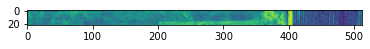

In [101]:
z= cv2.cvtColor(cv2.imread(os.path.join(parent_directory, "compile_dir/m_4812237_ne_10_060_20190806/chips/m_4812237_ne_10_060_20190806_24_06.jpg")),
                cv2.COLOR_BGR2GRAY)#,multichannel=True)
a = z[np.where((z != np.array(([0]*512)) ).all(axis=1))[0]]
plt.imshow(a)
a.shape

In [ ]:
x= cv2.cvtColor(cv2.imread(os.path.join(parent_directory, "compile_dir/m_4007203_ne_18_060_20190811/chips_positive/m_4007203_ne_18_060_20190811_01_19.jpg")),
                cv2.COLOR_BGR2GRAY)#,multichannel=True)plt.imshow(x[:23,:])
plt.imshow(x)

In [107]:
(score, diff) = compare_ssim(y,x,full=True)#,multichannel=True)

ValueError: Input images must have the same dimensions.

In [ ]:
make_tile_dir_and_get_correct_imgs(tile_name, compile_dir_path, tile_dir_path)

In [138]:
- make array
- save all scores,
- where score is greatest, move value

- if score is 1 move 

numpy.ndarray

In [152]:
tile_2_3_dir_path = os.path.join(parent_directory,"complete_dataset_","tiles","2-3")
tile_4_dir_path = os.path.join(parent_directory,"complete_dataset_","tiles","4")
take_2 = (os.path.join(parent_directory, "images_without_black_spots"))

In [ ]:
    fc.remove_thumbs(args.by_tile_correct_chips_w_black_sq_dir_path)
    fc.remove_thumbs(args.by_tile_correct_chips_wo_black_sq_dir_path)

In [166]:
for tile_name in tqdm.tqdm(sorted(os.listdir(tile_4_dir_path))):
    tile_name = os.path.splitext(tile_name)[0]
    make_tile_dir_and_get_correct_imgs_wo_black(tile_name, take_2, tile_4_dir_path)            

  1%|█                                                                              | 11/803 [04:12<5:03:35, 23.00s/it]


KeyboardInterrupt: 

In [198]:
a = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,
                                         "compile_dir/m_4007203_ne_18_060_20190811/chips/m_4007203_ne_18_060_20190811_01_19.jpg")),
                 cv2.COLOR_BGR2GRAY)
b = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,
                                         "images_without_black_spots/m_4007203_ne_18_060_20190811/chips/m_4007203_ne_18_060_20190811-01-19-000045.jpg")),
c = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,"compile_dir/m_4007203_ne_18_060_20190811/chips_positive/m_4007203_ne_18_060_20190811_01_19.jpg")),
                 cv2.COLOR_BGR2GRAY)

(score, diff) = compare_ssim(a, c, full=True)#,multichannel=True)
print("a,c",score )
row_dim = b.shape[0]
col_dim = b.shape[1]
a_temp = a[0:row_dim, 0:col_dim]
(score, diff) = compare_ssim(a_temp, b, full=True)#,multichannel=True)
print("a,b",score )
row_dim = b.shape[0]
col_dim = b.shape[1]
c_temp = c[0:row_dim, 0:col_dim]
(score, diff) = compare_ssim(c_temp, b, full=True)#,multichannel=True)
print("a,c",score )

a,c 0.9604125860471269
a,b 0.9990886157404214
a,c 0.03628798020566209


In [11]:

b = cv2.imread(os.path.join(parent_directory,
                                         "images_without_black_spots/m_4007203_ne_18_060_20190811/chips/m_4007203_ne_18_060_20190811-01-19-000045.jpg"))

row, col = b.shape


(512, 22, 3)

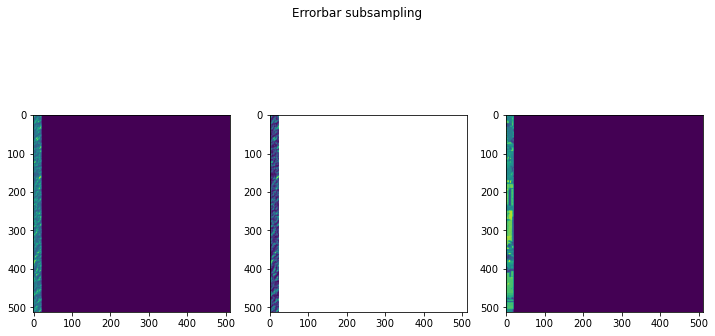

In [186]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(12, 6))

ax0.imshow(a)

ax1.imshow(b)

ax2.imshow(c)

fig.suptitle('Errorbar subsampling')
plt.show()

In [ ]:
            gray_labeled_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY) #image that had been labeled
            ## load correct image from tile             
            y, x = img_name.split("_")[-2:] #name of tif with the extension removed; y=row;x=col
            t_2_chip = tile_to_chip_array(tile, int(x), int(y), int(512)) # load tile to chip
            gray_t_2_chip = cv2.cvtColor(t_2_chip.astype(np.uint8), cv2.COLOR_BGR2GRAY) # make gray
            
            ## check if images are the same


In [23]:
bool_request, contents_json = False, __
contents_json

(512, 22, 3)

In [40]:
x = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,"compile_dir/m_4407521_sw_18_060_20190804/chips/m_4407521_sw_18_060_20190804_24_09.jpg")), cv2.COLOR_BGR2GRAY)[0:3]
y = cv2.cvtColor(cv2.imread(os.path.join(parent_directory,"compile_dir/m_4407521_sw_18_060_20190804/chips/m_4407521_sw_18_060_20190804_24_10.jpg")), cv2.COLOR_BGR2GRAY)[0:3]
compare_ssim(x, y, win_size = 3)# gaussian_weights = True, sigma = 1)

#win_size=None, gradient=False, data_range=None, channel_axis=None, multichannel=False, gaussian_weights=False, full=False, **kwargs)1`

0.7575251596106021

In [45]:
row, col = x.shape
if min(row,col) >= 3:
    print(3)

3


In [18]:
File "/hpc/home/csr33/cred/AST_dataset/data_download_and_preprocessing/compare_imgs_by_tile.py", line 64, in <module>
    main(args)
  File "/hpc/home/csr33/cred/AST_dataset/data_download_and_preprocessing/compare_imgs_by_tile.py", line 60, in main
    yx_list, standard_img_paths, standard_xml_paths)
  File "/hpc/home/csr33/cred/AST_dataset/data_download_and_preprocessing/data_eng/form_calcs.py", line 1734, in compare_imgs_wo_blk_pxls_state_yr_std_from_6_digit_xy_idxs
    if (np.sum(img) != 0) & (compare_images(correct_img_wo_black_sq, img)):
  File "/hpc/home/csr33/cred/AST_dataset/data_download_and_preprocessing/data_eng/form_calcs.py", line 1454, in compare_images
    (score, diff) = compare_ssim(gray_t_2_chip, gray_labeled_image, full=True)
  File "/hpc/home/csr33/.local/lib/python3.7/site-packages/skimage/_shared/utils.py", line 348, in fixed_func
    return func(*args, **kwargs)
  File "/hpc/home/csr33/.local/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py", line 169, in structural_similarity
    'win_size exceeds image extent. '
ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.


Test
Test
Test
Test
Test
Test
Test
Test
Test
Test
